<a href="https://colab.research.google.com/github/zavavan/case-2021-shared-task/blob/main/Evaluation_Pipeline_Task_2_CASE2022_Metrics_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DATA PRE-PROCESSING

# Setup

In [2]:
from IPython.display import clear_output
!pip install argparse
!pip install xtract
!pip install wget
import ipywidgets as widgets
import json
#clear_output()
import gzip
import shutil
import os
import wget
import csv
import linecache
from shutil import copyfile
import numpy as np
import pandas as pd
import datetime

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "D:\\Papers\\CASE2022\\SHARED TASK"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
INPUT_DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "SYSTEM_SUBMISSIONS")
os.makedirs(INPUT_DATA_PATH, exist_ok=True)

def load_system_submission(input_data_path,system_name,submission_name,_header):
    csv_path = os.path.join(input_data_path, system_name, submission_name)
    print('loading system submission data from file: ' + csv_path)
    return pd.read_csv(csv_path,header=_header)

#"D:\\knime_workspace\\Event Deduplication Evaluation New\\Data\\CASE2021\\Hu-Tiancheng-ETH\\submission.NoConflict.twitter.1.csv"

## Open Street Map (Nominatim API) location normalization

The String representation of the event location will be automatically converted into a pair of geographical coordinates by using the Nominatim search API (https://nominatim.org/release-docs/develop/api/Search/). While only the country attribute is mandatory, systems are expected to assign a description of the event location at the finest grained level possible, as otherwise geographical coordinate conversion from Nominatim will place the event at the geographical centroid of the polygon of the assigned administrative unit, which may penalize the correlation score on Prio-GRID cell aggregation.
   

In [ ]:
!pip install geopy
from geopy.geocoders import Nominatim

In [ ]:
geolocator = Nominatim(user_agent="case2022_task2",timeout=30)

In [ ]:
def make_structured_query(x, y, z):
    return {"city":x, "state":y, "country":z}

In [ ]:
location = geolocator.geocode("Minneapolis,Minnesota,USA",limit=1)
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Minneapolis, Hennepin County, Minnesota, United States
(44.9772995, -93.2654692)
{'place_id': 296997363, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136712, 'boundingbox': ['44.89015', '45.05125', '-93.3291271', '-93.193859'], 'lat': '44.9772995', 'lon': '-93.2654692', 'display_name': 'Minneapolis, Hennepin County, Minnesota, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.8571693135985456, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}


In [ ]:
dict = {"city":"Minneapolis", "state":"Minnesota", "country":"USA"}
location = geolocator.geocode(dict,limit=1)
print(location.address)
print((location.latitude, location.longitude))
print(location.raw)

Minneapolis, Hennepin County, Minnesota, United States
(44.9772995, -93.2654692)
{'place_id': 296997363, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'relation', 'osm_id': 136712, 'boundingbox': ['44.89015', '45.05125', '-93.3291271', '-93.193859'], 'lat': '44.9772995', 'lon': '-93.2654692', 'display_name': 'Minneapolis, Hennepin County, Minnesota, United States', 'class': 'boundary', 'type': 'administrative', 'importance': 0.8571693135985456, 'icon': 'https://nominatim.openstreetmap.org/ui/mapicons/poi_boundary_administrative.p.20.png'}


### System Output File

In [ ]:
df = load_system_submission(INPUT_DATA_PATH,"Hu-Tiancheng-ETH","submission.NoConflict.nyt.1.csv",None)
df.columns =['id','city', 'state', 'country', 'date','url']
df.tail()

loading system submission data from file: D:\Papers\CASE2022\SHARED TASK\SYSTEM_SUBMISSIONS\Hu-Tiancheng-ETH\submission.NoConflict.nyt.1.csv


,id,city,state,country,date,url
135,116,City Hall Park,City Hall Park,USA,2020-06-23,nyt://article/08c95638-5ff4-5a0e-bbcb-c71df586...
136,117,New York City,New York,USA,2020-06-28,nyt://article/d321e592-103c-589b-9a87-197a7946...
137,118,Seattle,Washington,USA,2020-06-28,nyt://article/0bbfbc24-391c-512c-bf82-934841e5...
138,119,St Louis,Missouri,USA,2020-06-22,nyt://article/a41426fc-ae75-5145-a731-e7480636...
139,120,Minneapolis,Minnesota,USA,2020-06-29,nyt://article/5c7e0c68-2604-505a-940b-1c8cd651...


In [ ]:
locations = df[['city','state','country']].value_counts(ascending=False).reset_index(name='count')[['city','state','country']]

In [ ]:
locations

,city,state,country
0,Minneapolis,Minnesota,USA
1,Washington,District of Columbia,USA
2,New York City,New York,USA
3,New York,New York,USA
4,Brooklyn,New York,USA
...,...,...,...
59,Manhattan,New York,USA
60,Massachusetts,Massachusetts,USA
61,Mexico City,Mexico City,Mexico
62,Miami,Florida,USA


In [ ]:
results = [geolocator.geocode(make_structured_query(x,y,z)) for x, y, z in locations[['city','state','country']].to_numpy()]


In [ ]:
results

[Location(Minneapolis, Hennepin County, Minnesota, United States, (44.9772995, -93.2654692, 0.0)),
 Location(Washington, District of Columbia, United States, (38.8950368, -77.0365427, 0.0)),
 Location(City of New York, New York, United States, (40.7127281, -74.0060152, 0.0)),
 Location(City of New York, New York, United States, (40.7127281, -74.0060152, 0.0)),
 Location(Brooklyn, Kings County, City of New York, New York, United States, (40.6526006, -73.9497211, 0.0)),
 Location(Young America, Norwood Young America, Carver County, Minnesota, 55397, United States, (44.7827399, -93.913579, 0.0)),
 Location(Seattle, King County, Washington, United States, (47.6038321, -122.330062, 0.0)),
 Location(Atlanta, Fulton County, Georgia, 30303, United States, (33.7489924, -84.3902644, 0.0)),
 Location(Buffalo, Erie County, New York, United States, (42.8867166, -78.8783922, 0.0)),
 Location(Los Angeles, Los Angeles County, CAL Fire Southern Region, California, United States, (34.0536909, -118.24276

In [ ]:
locations['lat'] = [result.latitude if result is not None else 'NaN' for result in results]
locations['lon'] = [result.longitude if result is not None else 'NaN' for result in results]

In [ ]:
locations

,city,state,country,lat,lon
0,Minneapolis,Minnesota,USA,44.9773,-93.265469
1,Washington,District of Columbia,USA,38.895037,-77.036543
2,New York City,New York,USA,40.712728,-74.006015
3,New York,New York,USA,40.712728,-74.006015
4,Brooklyn,New York,USA,40.652601,-73.949721
...,...,...,...,...,...
59,Manhattan,New York,USA,40.789624,-73.959894
60,Massachusetts,Massachusetts,USA,NaN,NaN
61,Mexico City,Mexico City,Mexico,NaN,NaN
62,Miami,Florida,USA,25.774173,-80.19362


In [ ]:
locations.loc[(locations['city'] == 'Minneapolis') & (locations['state'] == 'Minnesota'), 'lat'].iloc[0]

44.9772995

In [ ]:
df['lat'] = [ locations.loc[(locations['city'] == x) & (locations['state'] == y) & (locations['country'] == z), 'lat'].iloc[0]  for x,y,z in df[['city','state','country']].to_numpy()]
df['lon'] = [ locations.loc[(locations['city'] == x) & (locations['state'] == y) & (locations['country'] == z), 'lon'].iloc[0]  for x,y,z in df[['city','state','country']].to_numpy()]

In [ ]:
df

,id,city,state,country,date,url,lat,lon
0,0,Minneapolis,Minnesota,USA,2020-05-20,nyt://article/89a6704f-755c-5d5b-b7fc-2370e22e...,44.9773,-93.265469
1,1,Minneapolis,Minnesota,USA,2020-05-27,nyt://article/1fba79e8-66a4-5cd6-adcd-79e6c323...,44.9773,-93.265469
2,2,Minneapolis,Minnesota,USA,2020-05-21,nyt://article/e0981348-6e47-556b-825b-065ab8f5...,44.9773,-93.265469
3,3,Kentucky,Kentucky,USA,2020-05-28,nyt://article/4148dca6-1e6c-568d-826d-a75740be...,NaN,NaN
4,4,Minnesota,Minnesota,USA,2020-05-29,nyt://article/b956312e-0b6e-588e-8616-169c1d4a...,43.84244,-93.832384
...,...,...,...,...,...,...,...,...
135,116,City Hall Park,City Hall Park,USA,2020-06-23,nyt://article/08c95638-5ff4-5a0e-bbcb-c71df586...,NaN,NaN
136,117,New York City,New York,USA,2020-06-28,nyt://article/d321e592-103c-589b-9a87-197a7946...,40.712728,-74.006015
137,118,Seattle,Washington,USA,2020-06-28,nyt://article/0bbfbc24-391c-512c-bf82-934841e5...,47.603832,-122.330062
138,119,St Louis,Missouri,USA,2020-06-22,nyt://article/a41426fc-ae75-5145-a731-e7480636...,38.631966,-90.242876


### Gold Standard File

In [ ]:
gs = load_system_submission("D:\\Papers\\CASE2022\\SHARED TASK\\SYSTEM_SUBMISSIONS","GoldStandard","protest_events_merged.csv",0)
#df.columns =['id','city', 'state', 'country', 'date','url']


loading system submission data from file: D:\Papers\CASE2022\SHARED TASK\SYSTEM_SUBMISSIONS\GoldStandard\protest_events_merged.csv


In [ ]:
len(gs)

7976

In [ ]:
locations_gs = gs[['City','Region','Country']].value_counts(ascending=False).reset_index(name='count')[['City','Region','Country']]

In [ ]:
locations_gs

,City,Region,Country
0,New York,New York,USA
1,Washington,District of Columbia,USA
2,Portland,Oregon,USA
3,San Francisco,California,USA
4,Los Angeles,California,USA
...,...,...,...
3995,Hillsborough,North Carolina,USA
3996,Hillsdale,Michigan,USA
3997,Hillside,New Jersey,USA
3998,Hilton,New York,USA


In [ ]:
# Iterating over two columns, use `zip`
results_gs = [geolocator.geocode(make_structured_query(x,y,z)) for x, y, z in locations_gs[['City','Region','Country']].to_numpy()]


In [ ]:
locations_gs['lat'] = [result.latitude if result is not None else 'NaN' for result in results_gs]
locations_gs['lon'] = [result.longitude if result is not None else 'NaN' for result in results_gs]

In [ ]:
gs['lat'] = [ locations_gs.loc[(locations_gs['City'] == x) & (locations_gs['Region'] == y) & (locations_gs['Country'] == z), 'lat'].iloc[0]  for x,y,z in gs[['City','Region','Country']].to_numpy()]
gs['lon'] = [ locations_gs.loc[(locations_gs['City'] == x) & (locations_gs['Region'] == y) & (locations_gs['Country'] == z), 'lon'].iloc[0]  for x,y,z in gs[['City','Region','Country']].to_numpy()]

In [ ]:
len(gs)

7976

## PRIO-GRID normalization

We join event point shapefiles with a PRIO-GRID shapefile. PRIO-GRID is a vector grid network with a resolution of 0.5 x 0.5 decimal degrees (~55 km), covering all terrestrial areas of the world.
The following code is the equivalent of the following QGIS procedure:
Menu > Vector > Data Management Tools > Join attributes by location 
Target : points layer, Join layer: polygons layer. That way info from your districts goes into your points Geometric predicate : Check ON all the options: intersects, touches etc. I haven't looked further into this yet but just one option had not worked out earlier.
Attributes summary : Take attributes of first located feature Joined table : 
Keep all records ... that will preserve the points that were outside of all the wards too

In [ ]:
import sys
sys.path

['C:\\Users\\Vanni',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\python310.zip',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\DLLs',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env',
 '',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib\\site-packages',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib\\site-packages\\win32',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib\\site-packages\\Pythonwin']

In [ ]:
import pandas
pandas.__path__

['C:\\Users\\Vanni\\anaconda3\\envs\\case2022_env\\lib\\site-packages\\pandas']

In [ ]:
paths = !type -a python
for path in set(paths):
    path = path.split()[-1]
    print(path)
    !{path} -c "import sys; print(sys.path)"
    print()

-a.

python.


"-a." non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.



specificato.


"python." non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.
"specificato." non Š riconosciuto come comando interno o esterno,
 un programma eseguibile o un file batch.


In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import scipy
import shapely
import matplotlib.pyplot as plt
import bokeh
import cartopy
import statsmodels
import sklearn
import osmnx
import folium

In [ ]:
# Filepath
tic = time.time()
fp = "D:\\Papers\\Work_Documentation\\CASE2021\\priogrid_shapefiles\\priogrid_cell.shp"

# Read the data
priogrid = gpd.read_file(fp)
toc = time.time()
print('time to read the priogrid shape file = ' + str((toc - tic)/60) + ' minutes' )


time to read the priogrid shape file = 0.28879652818044027 minutes


In [ ]:
len(priogrid)

259200

In [ ]:
# Filepath
fp = "D:\Papers\Work_Documentation\CASE2021\data\BLMGoldStandard\gadm36_USA_shp"

usa = gpd.read_file(fp)
usa.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   GID_0     1 non-null      object  
 1   NAME_0    1 non-null      object  
 2   geometry  1 non-null      geometry
dtypes: geometry(1), object(2)
memory usage: 152.0+ bytes


### Intersection of PRIOGrid with the US country shape file

In [ ]:
import time
import shapely.speedups

shapely.speedups.enable()
# enable shapely.speedups which makes queries running faster.

tic = time.time()
priogrid_mask = priogrid.within(usa.loc[0, 'geometry']) 
# selecting the polygon's geometry field to filter out points that 
# are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str(toc - tic)/60 + ' minutes' )

priogrid_usa = usa.loc[priogrid_mask]



KeyboardInterrupt



In [ ]:
len(priogrid_usa)

### Gold Standard File
###### reading the PrioGrid-joined Gold Standard from file:

In [ ]:
gs = pd.read_csv(csv_path,header=True)

C:\Users\Vanni\anaconda3\envs\case2022_env\lib\site-packages\IPython\core\interactiveshell.py:3398: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


time to execute the sjoin with PRIOGrid shape file = -52.42990779876709s


,Unnamed: 0,ID,City,Region,Country,Source_URL,Date,X_Longitude,Y_Latitude,Gold_Standard,lat,lon,geometry,index_right,gid
0,0,1,Juneau,Alaska,USA,https://www.juneauempire.com/news/hundreds-gat...,2020-06-06,-134.40679,58.29973,1,58.30195,-134.419734,POINT (-134.41973 58.30195),45957,213212
1,1,2,Anchorage,Alaska,USA,https://www.adn.com/alaska-news/anchorage/2020...,2020-05-30,-149.85825,61.21753,1,61.216313,-149.894852,POINT (-149.89485 61.21631),41686,217501
4246,4246,4247,Anchorage,Alaska,USA,https://www.adn.com/alaska-news/anchorage/2020...,2020-06-05,NaN,NaN,0,61.216313,-149.894852,POINT (-149.89485 61.21631),41686,217501
2,2,3,Fairbanks,Alaska,USA,http://www.newsminer.com/alerts/hundreds-gathe...,2020-05-30,-147.72210,64.84525,1,64.837845,-147.716675,POINT (-147.71668 64.83785),36650,222545
4631,4631,4632,Fairbanks,Alaska,USA,www.newsminer.com/news/local_news/white-coats-...,2020-06-06,NaN,NaN,0,64.837845,-147.716675,POINT (-147.71668 64.83785),36650,222545


In [ ]:
len(join)

7883

### Intersection with the US country shape file

In [ ]:
import shapely.speedups

shapely.speedups.enable() 
# enable shapely.speedups which makes queries running faster.

tic = time.time()
gs_mask = join.within(usa.loc[0, 'geometry']) 
# selecting the polygon's geometry field to filter out points that 
# are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str(toc - tic)/60 + ' minutes' )


pip_usa = usa.loc[gs_mask]

#data_gs = []
#for index, orig in gs_gdf.iterrows():
 #   for index2, ref in usa.iterrows():      
  #      if ref['geometry'].intersects(orig['geometry']): 
   #      owdspd=orig['ID']
    #     data_gs.append({'geometry':ref['geometry'].intersection(orig['geometry']),'wdspd':owdspd})

time to execute the intersaction with USA shape file = -3290.292199611664s


In [ ]:
pip_usa = join.loc[gs_mask]

In [ ]:
pip_usa.head()

,Unnamed: 0,ID,City,Region,Country,Source_URL,Date,X_Longitude,Y_Latitude,Gold_Standard,lat,lon,geometry,index_right,gid
0,0,1,Juneau,Alaska,USA,https://www.juneauempire.com/news/hundreds-gat...,2020-06-06,-134.40679,58.29973,1,58.30195,-134.419734,POINT (-134.41973 58.30195),45957,213212
1,1,2,Anchorage,Alaska,USA,https://www.adn.com/alaska-news/anchorage/2020...,2020-05-30,-149.85825,61.21753,1,61.216313,-149.894852,POINT (-149.89485 61.21631),41686,217501
4246,4246,4247,Anchorage,Alaska,USA,https://www.adn.com/alaska-news/anchorage/2020...,2020-06-05,NaN,NaN,0,61.216313,-149.894852,POINT (-149.89485 61.21631),41686,217501
2,2,3,Fairbanks,Alaska,USA,http://www.newsminer.com/alerts/hundreds-gathe...,2020-05-30,-147.72210,64.84525,1,64.837845,-147.716675,POINT (-147.71668 64.83785),36650,222545
4631,4631,4632,Fairbanks,Alaska,USA,www.newsminer.com/news/local_news/white-coats-...,2020-06-06,NaN,NaN,0,64.837845,-147.716675,POINT (-147.71668 64.83785),36650,222545


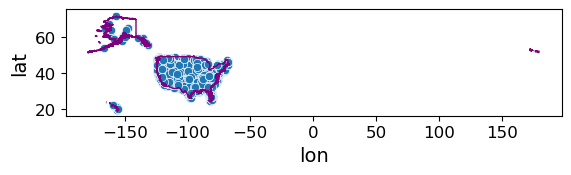

In [ ]:
import seaborn as sns

fig, ax = plt.subplots()
ax = sns.scatterplot(x='lon', y='lat', data=pip_usa)
usa.plot(ax=ax, facecolor='none', edgecolor='purple');
#plt.tight_layout();

### System Output File

In [ ]:
events = df
len(events)

140

In [ ]:
events_gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat))

In [ ]:
events_gdf = events_gdf.set_crs("EPSG:4326")

In [ ]:
len(events_gdf)

140

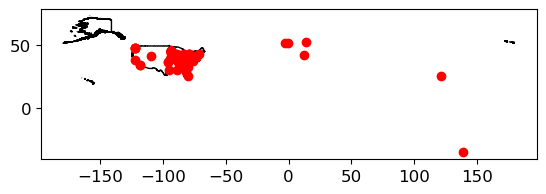

In [ ]:
# We restrict to US.
ax = usa.plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
events_gdf.plot(ax=ax, color='red')

plt.show()


In [ ]:
# Make a spatial join
tic = time.time()
join1 = events_gdf.sjoin(priogrid, how="inner", op="within")
toc = time.time()
print('time to execute the sjoin with PRIOGrid shape file = ' + str((toc - tic)/60) + ' minutes' )
join1.head(5)

C:\Users\Vanni\anaconda3\envs\case2022_env\lib\site-packages\IPython\core\interactiveshell.py:3398: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

In [ ]:
len(join1)

126

In [ ]:
shapely.speedups.enable() 
# enable shapely.speedups which makes queries running faster.

tic = time.time()
gs_mask1 = join1.within(usa.loc[0, 'geometry']) 
# selecting the polygon's geometry field to filter out points that 
# are not overlaid
toc = time.time()
print('time to execute the intersection with USA shape file = ' + str((toc - tic)/60) + ' minutes' )

events_usa = join1.loc[gs_mask1]

#data_gs = []
#for index, orig in gs_gdf.iterrows():
 #   for index2, ref in usa.iterrows():      
  #      if ref['geometry'].intersects(orig['geometry']): 
   #      owdspd=orig['ID']
    #     data_gs.append({'geometry':ref['geometry'].intersection(orig['geometry']),'wdspd':owdspd})

time to execute the intersection with USA shape file = 5.119512776533763 minutes


In [ ]:
len(events_usa)

120

In [ ]:
events_usa.head()

,id,city,state,country,date,url,lat,lon,geometry,index_right,gid
0,0,Minneapolis,Minnesota,USA,2020-05-20,nyt://article/89a6704f-755c-5d5b-b7fc-2370e22e...,44.9773,-93.265469,POINT (-93.26547 44.97730),65331,193854
1,1,Minneapolis,Minnesota,USA,2020-05-27,nyt://article/1fba79e8-66a4-5cd6-adcd-79e6c323...,44.9773,-93.265469,POINT (-93.26547 44.97730),65331,193854
2,2,Minneapolis,Minnesota,USA,2020-05-21,nyt://article/e0981348-6e47-556b-825b-065ab8f5...,44.9773,-93.265469,POINT (-93.26547 44.97730),65331,193854
5,5,Minneapolis,Minnesota,USA,2020-05-22,nyt://article/d05f9fef-2faa-5300-b531-62d3e556...,44.9773,-93.265469,POINT (-93.26547 44.97730),65331,193854
11,11,Minneapolis,Minnesota,USA,2020-05-30,nyt://article/3dbfc5a2-b5d5-5777-8755-e766fcbb...,44.9773,-93.265469,POINT (-93.26547 44.97730),65331,193854


### Column filtering

In [ ]:
events_usa = events_usa[['id', 'city', 'state', 'country','date', 'url','lat','lon','gid']]

In [ ]:
gs_events_usa = pip_usa[['ID', 'City', 'Region', 'Country','Date', 'Source_URL','lat','lon','gid']]

In [ ]:
dict = {'ID': 'id',
        'City': 'city',
        'Region': 'state',
        'Country': 'country',
         'Date': 'date',
       'Source_URL': 'url'}
 
# call rename () method
gs_events_usa.rename(columns=dict,inplace=True)

C:\Users\Vanni\AppData\Local\Temp\ipykernel_30644\2869212930.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_events_usa.rename(columns=dict,inplace=True)


In [ ]:
gs_events_usa.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7869 entries, 0 to 7623
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       7869 non-null   int64 
 1   city     7869 non-null   object
 2   state    7869 non-null   object
 3   country  7869 non-null   object
 4   date     7869 non-null   object
 5   url      7869 non-null   object
 6   lat      7869 non-null   object
 7   lon      7869 non-null   object
 8   gid      7869 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 614.8+ KB


### Date column type conversion and filtering by date

In [ ]:
gs_events_usa['date'] = pd.to_datetime(gs_events_usa['date'], errors='raise')

C:\Users\Vanni\AppData\Local\Temp\ipykernel_30644\12689228.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gs_events_usa['date'] = pd.to_datetime(gs_events_usa['date'], errors='raise')


In [ ]:
gs_events_usa = gs_events_usa[(gs_events_usa['date'] >= '25-5-2020') & (gs_events_usa['date'] <= '30-6-2020')]

In [ ]:
events_usa['date'] = pd.to_datetime(events_usa['date'], errors='raise')

In [ ]:
events_usa = events_usa[(gs_events_usa['date'] >= '25-5-2020') & (events_usa['date'] <= '30-6-2020')]

C:\Users\Vanni\AppData\Local\Temp\ipykernel_30644\2068868447.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  events_usa = events_usa[(gs_events_usa['date'] >= '25-5-2020') & (events_usa['date'] <= '30-6-2020')]


In [ ]:
#group_by_gid = gs_events_usa.groupby('gid').size().reset_index(name='count').sort_values(['count'], ascending=False)
#group_by_gid

In [ ]:
#events_usa_group_by_gid = events_usa.groupby('gid').size().reset_index(name='count').sort_values(['count'], ascending=False)

### Time shift (2 days) for news data

In [ ]:
#events_usa_times =  events_usa['date']
#events_usa_time_shifts = [ x + datetime.timedelta(days=2) for x in events_usa['date']  ]

### Sorting by date

In [ ]:
gs_events_usa.sort_values(by="date")
events_usa.sort_values(by="date")

,id,city,state,country,date,url,lat,lon,gid
0,0,Minneapolis,Minnesota,USA,2020-05-20,nyt://article/89a6704f-755c-5d5b-b7fc-2370e22e...,44.9773,-93.265469,193854
2,2,Minneapolis,Minnesota,USA,2020-05-21,nyt://article/e0981348-6e47-556b-825b-065ab8f5...,44.9773,-93.265469,193854
5,5,Minneapolis,Minnesota,USA,2020-05-22,nyt://article/d05f9fef-2faa-5300-b531-62d3e556...,44.9773,-93.265469,193854
8,8,Florida,Florida,USA,2020-05-23,nyt://article/bed091f4-9e04-554e-b127-a5029f05...,28.542111,-81.37903,170838
13,13,The,The,USA,2020-05-24,nyt://article/3635bf6d-a5b5-591a-a9ec-4541e57e...,40.206632,-88.371221,187384
...,...,...,...,...,...,...,...,...,...
130,111,New York City,New York,USA,2020-06-24,nyt://article/0a78e44d-07d8-5372-afb7-79909161...,40.712728,-74.006015,188132
133,114,Louisville,Kentucky,USA,2020-06-27,nyt://article/8e15b3ce-f7cf-5c2c-9398-6d125943...,38.254238,-85.759407,184509
136,117,New York City,New York,USA,2020-06-28,nyt://article/d321e592-103c-589b-9a87-197a7946...,40.712728,-74.006015,188132
137,118,Seattle,Washington,USA,2020-06-28,nyt://article/0bbfbc24-391c-512c-bf82-934841e5...,47.603832,-122.330062,198116


In [ ]:
time_series_gs_events_usa = pd.DataFrame(columns=['Day','ProtestCells'])

time_series_gs_events_usa.Day = [  group[0] for group in gs_events_usa.groupby(gs_events_usa['date']) ]
time_series_gs_events_usa.ProtestCells = [   group[1]['gid'].nunique() for group in gs_events_usa.groupby(gs_events_usa['date']) ]

time_series_gs_events_usa

#test = pd.concat(DFList)
#test.head(30)

,Day,ProtestCells
0,2020-05-26,1
1,2020-05-27,1
2,2020-05-28,9
3,2020-05-29,48
4,2020-05-30,251
5,2020-05-31,375
6,2020-06-01,357
7,2020-06-02,353
8,2020-06-03,309
9,2020-06-04,288


In [ ]:
time_series_events_usa = pd.DataFrame(columns=['Day','ProtestCells'])

time_series_events_usa.Day = [  group[0] for group in events_usa.groupby(events_usa['date']) ]
time_series_events_usa.ProtestCells = [   group[1]['gid'].nunique() for group in events_usa.groupby(events_usa['date']) ]

time_series_events_usa

#test = pd.concat(DFList)
#test.head(30)

,Day,ProtestCells
0,2020-05-20,1
1,2020-05-21,1
2,2020-05-22,1
3,2020-05-23,1
4,2020-05-24,3
5,2020-05-25,2
6,2020-05-26,2
7,2020-05-27,1
8,2020-05-28,1
9,2020-05-29,6


In [ ]:
joined_data_frame1 = (pd.merge(time_series_gs_events_usa, time_series_events_usa, on='Day', how='outer')
        .fillna(0)
        .sort_values('Day')
        .set_index('Day'))

In [ ]:
joined_data_frame1.rename({'ProtestCells_x':'GoldStandard','ProtestCells_y':'NoConflict3' }, axis=1)

,GoldStandard,NoConflict3
Day,,
2020-05-20,0.0,1.0
2020-05-21,0.0,1.0
2020-05-22,0.0,1.0
2020-05-23,0.0,1.0
2020-05-24,0.0,3.0
2020-05-25,0.0,2.0
2020-05-26,1.0,2.0
2020-05-27,1.0,1.0
2020-05-28,9.0,1.0


<Figure size 7800x4200 with 0 Axes>

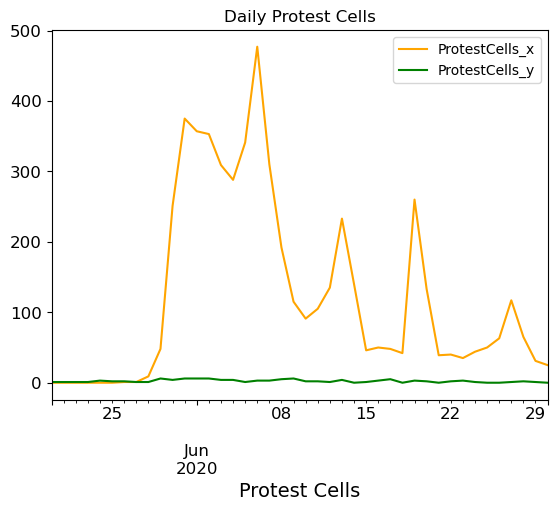

In [ ]:
# to set the plot size
plt.figure(figsize=(26, 14), dpi=300)

# using .plot method
# passing colors as a list
joined_data_frame1.plot(label='joined_data_frame1', color=['orange', 'green'])

# adding title
plt.title('Daily Protest Cells')

# adding label to x-axis
plt.xlabel('Day')

# adding label to y-axis
plt.xlabel('Protest Cells')

# adding legend.
plt.legend()
